In [23]:
%%capture 
import pandas as pd
import numpy as np
import os
from scipy import stats

pd.options.mode.chained_assignment = None

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# UWB Pilot data

Here we study the pilot results. The group data won't contain psychometrics but we still want to investigate psi statistics, for example, or relationships between group size and play area.

`psi_duration` represents the number of frames (at 12FPS) elapsed until the last value of $\Psi$ higher than 3 that the group had.
`total_duration` represents for how long the game actually recorded positions. 

For the groups who did not have a Psi above 3 during the game (i.e. not winning groups), we replace the `psi_duration` with total duration.


## Load group data

In [215]:
groups_df = pd.read_csv("games_data.csv")
groups_df['group'] = groups_df['name']
groups_df = groups_df.set_index('group')

In [216]:
groups_df['duration'] = groups_df['psi_duration']
groups_df.loc[groups_df['psi_duration'].isna(), 'duration'] =  groups_df.loc[groups_df['psi_duration'].isna(), 'total_duration']  

In [217]:
groups_df['area'] = groups_df['area_x'] * groups_df['area_y']

In [218]:
groups_df['success'] = groups_df['rt_max_psi'] > 3

In [219]:
groups_df = groups_df.drop(['name', 'date', 'time', 'psi_duration', 'total_duration', 'area_x', 'area_y', 'area_z'], axis = 1)

## Load trajectory emergence data
We read the values of emergence $\Psi$ computed post-hoc. We cut off the first `START_THRESHOLD` values.

We compute the maximum, min, mean, std and median $\Psi$.

**NB: normalising positions by play area to the unit circle has no effect on the post-hoc computation of $\Psi$**

In [177]:
FRAMERATE = 12
START_THRESHOLD = FRAMERATE * 15

In [187]:
psi, pstats = {}, {}
for g in groups_df.index:
    start  = START_THRESHOLD
    
    if os.path.exists(f"psi/{g}-psi.csv"):
        psis = pd.read_csv(f"psi/{g}-psi.csv")
        psi[g] = np.array(psis, dtype = float)
        pstats[g] = {
            'max_psi' : psi[g].max(),
            'min_psi' : psi[g].min(),
            'avg_psi' : psi[g].mean(),
            'med_psi' : np.median(psi[g]),
            'std_psi' : psi[g].std(),
        }

In [231]:
psi_df = pd.DataFrame(pstats).T
psi_df = psi_df.reset_index()
psi_df = psi_df.rename({'index':'group'}, axis = 1)

## Analysing game outcome

In [232]:
psi_df2 = pd.melt(psi_df, id_vars = 'group')
psi_df2 = psi_df2.join(groups_df.drop('rt_max_psi', axis = 1), on = 'group')

In [233]:
psi_df2.head()

,group,variable,value,num_players,task,duration,area,success
0,20240207-185759,max_psi,4.766305,5,circle,970.0,35.2182,True
1,20240207-190357,max_psi,4.018955,5,static,2005.0,35.2182,True
2,20240207-191454,max_psi,2.143425,5,mostly_static,1125.0,35.2182,False
3,20240207-192351,max_psi,-4.612398,5,line,878.0,35.2182,False
4,20240207-193253,max_psi,1.975805,5,line,782.0,35.2182,False


### Preview $\Psi$ statistics by task and duration

**NB** At the moment the unclear tasks were removed. 

In [234]:
# for now let's drop all unclear tasks
tasks = ['static', 'line', 'circle', 'infinity' ]
psi_df3 = psi_df2[psi_df2.task.isin(tasks)] 

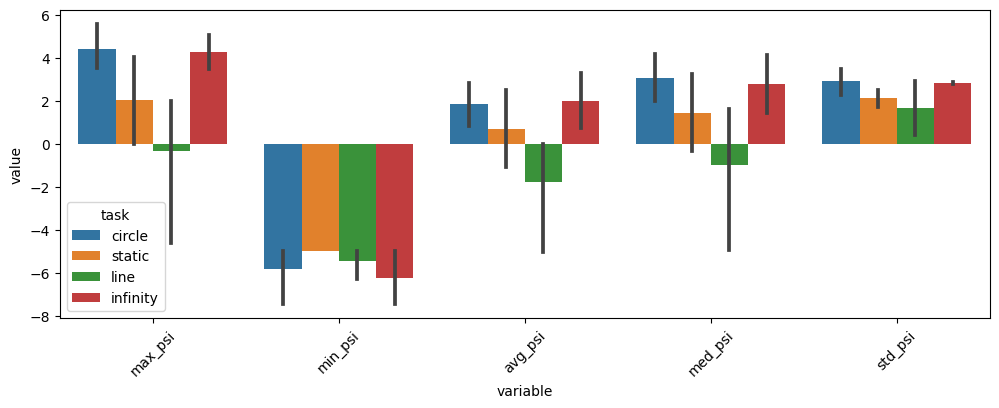

In [235]:
plt.rcParams['figure.figsize'] = (12,4)
sns.barplot(data=psi_df3, x='variable', y='value', hue='task')
plt.xticks(rotation=45);

In [240]:
psi_df4 = psi_df.join(groups_df.drop('rt_max_psi', axis = 1), on = 'group')
psi_df4.head()

,group,max_psi,min_psi,avg_psi,med_psi,std_psi,num_players,task,duration,area,success
0,20240207-185759,4.766305,-5.00000,2.098013,4.042348,3.654020,5,circle,970.0,35.2182,True
1,20240207-190357,4.018955,-5.00000,2.481359,3.230960,2.506946,5,static,2005.0,35.2182,True
2,20240207-191454,2.143425,-5.00000,0.499627,1.559444,2.558558,5,mostly_static,1125.0,35.2182,False
3,20240207-192351,-4.612398,-6.29613,-5.032585,-4.932134,0.386833,5,line,878.0,35.2182,False
4,20240207-193253,1.975805,-5.00000,-0.037360,1.616545,2.903032,5,line,782.0,35.2182,False


### Preview $\Psi$ statistics versus durations

**NB** This includes **all** games from all three pilot days.

<Axes: xlabel='duration', ylabel='max_psi'>

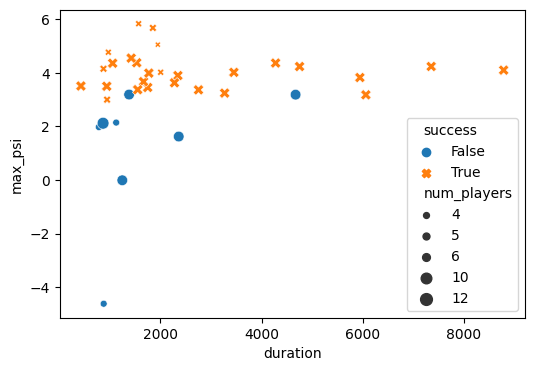

In [251]:
plt.rcParams['figure.figsize'] = (6,4)
sns.scatterplot(data = psi_df4, x = 'duration', y = 'max_psi', 
                style = 'success', hue = 'success', size='num_players')

## Preview gameplay trajectories

/home/m/.local/lib/python3.9/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


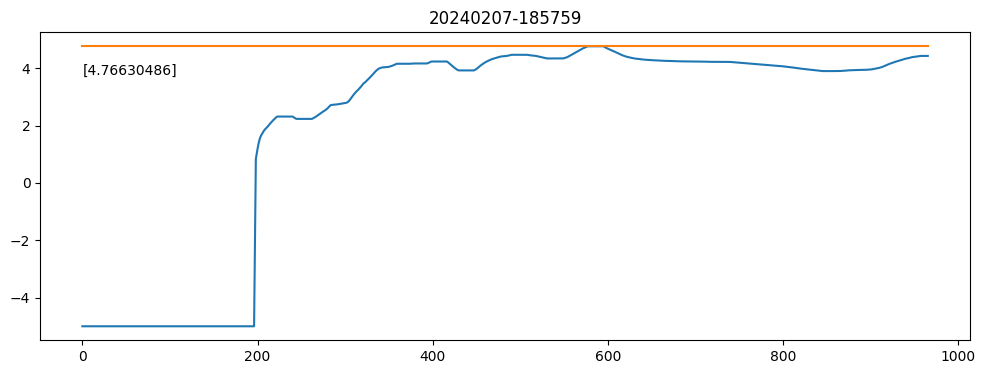

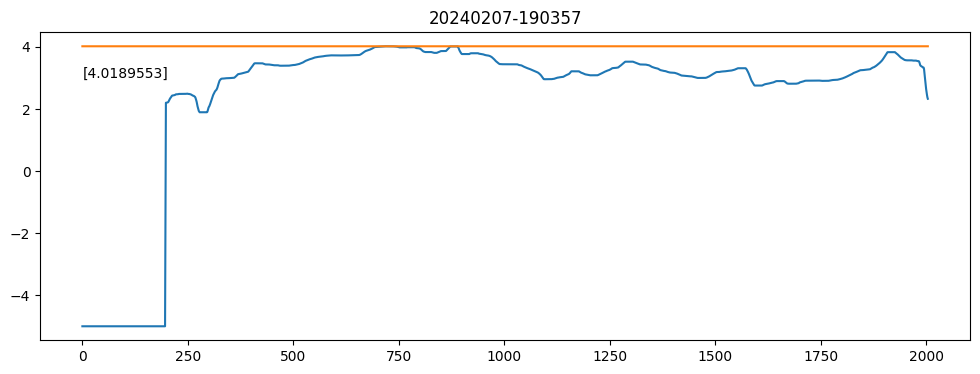

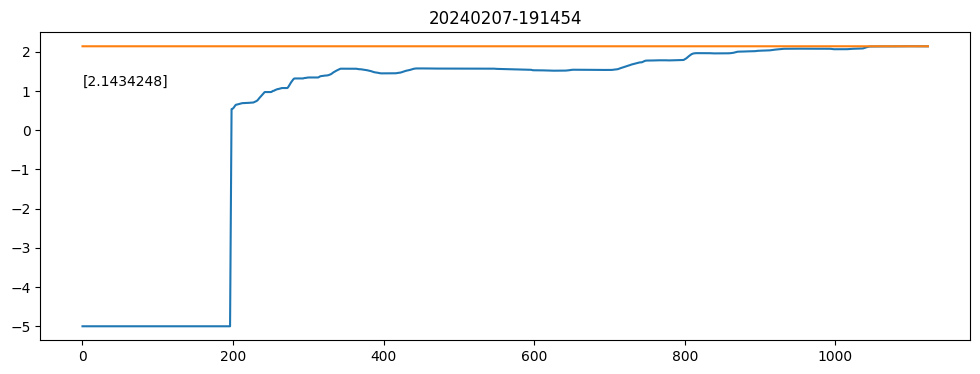

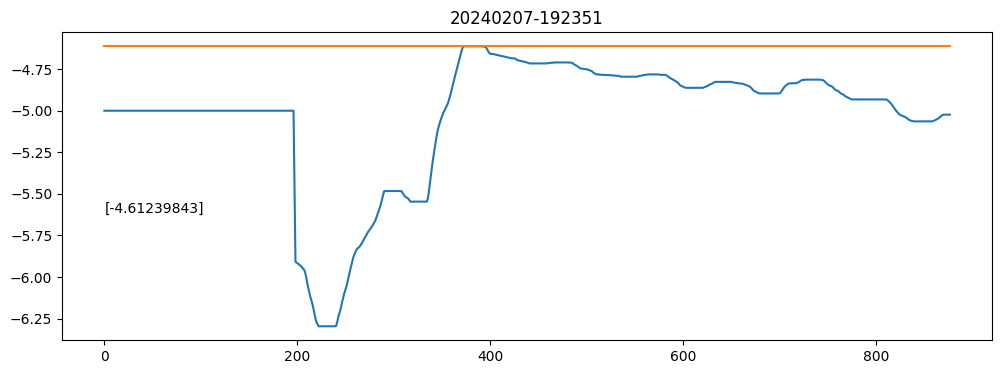

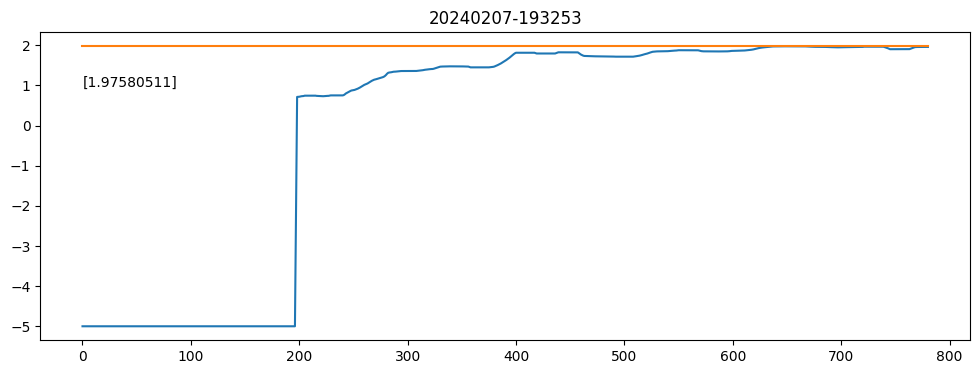

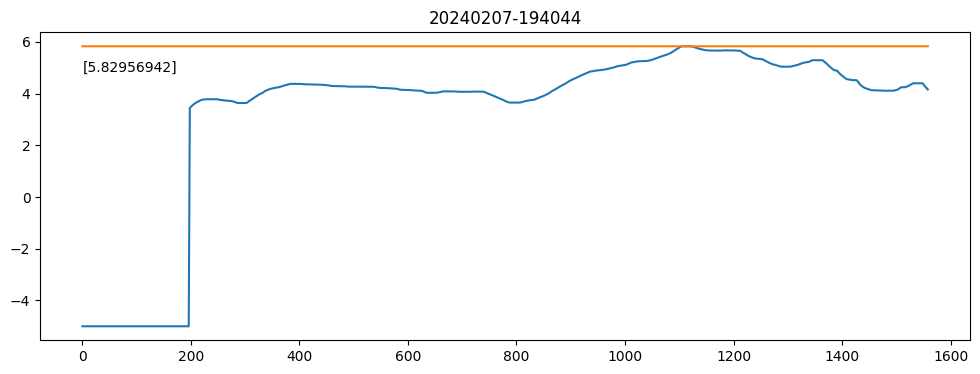

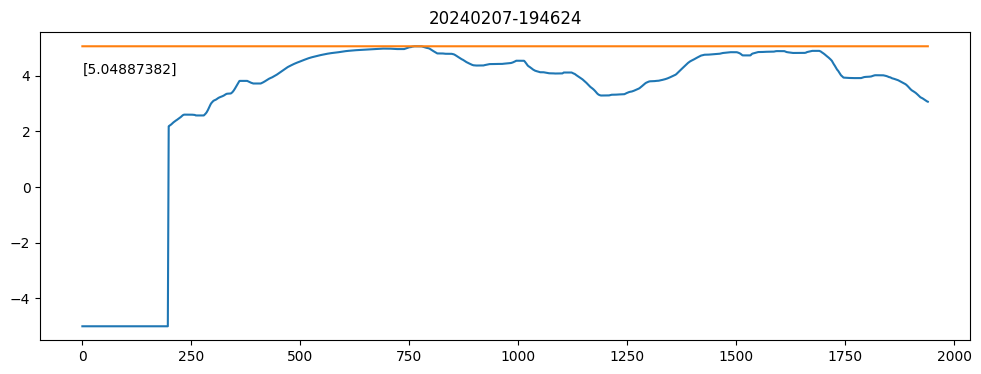

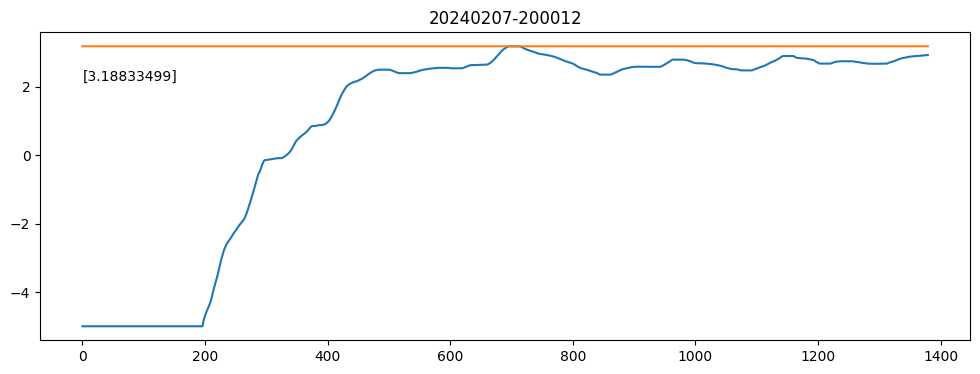

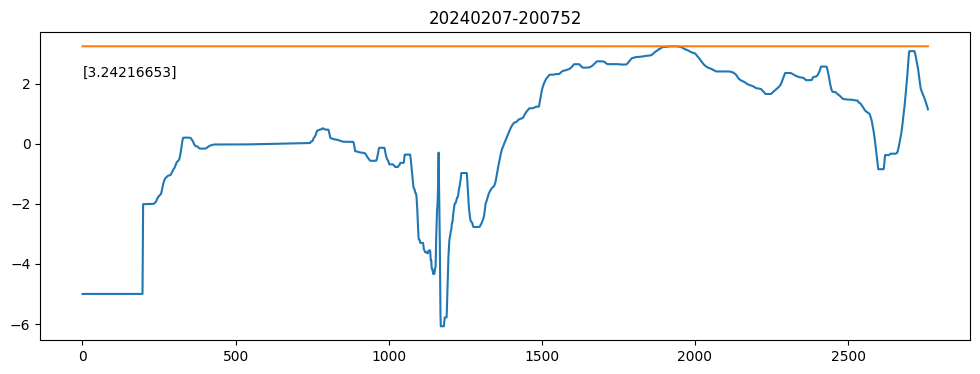

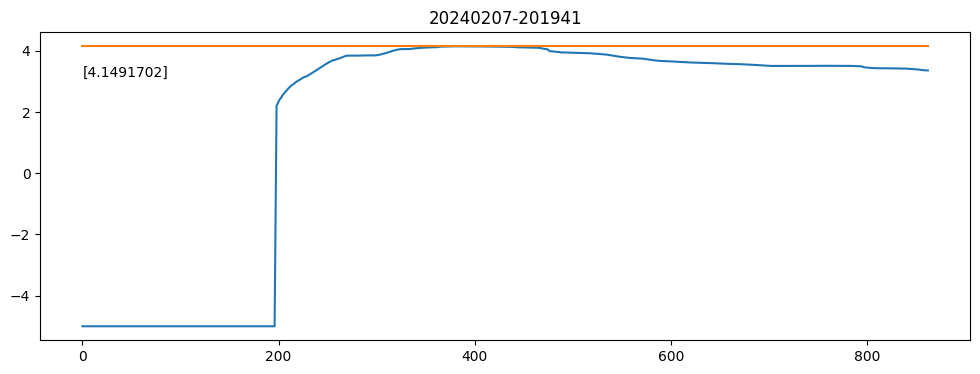

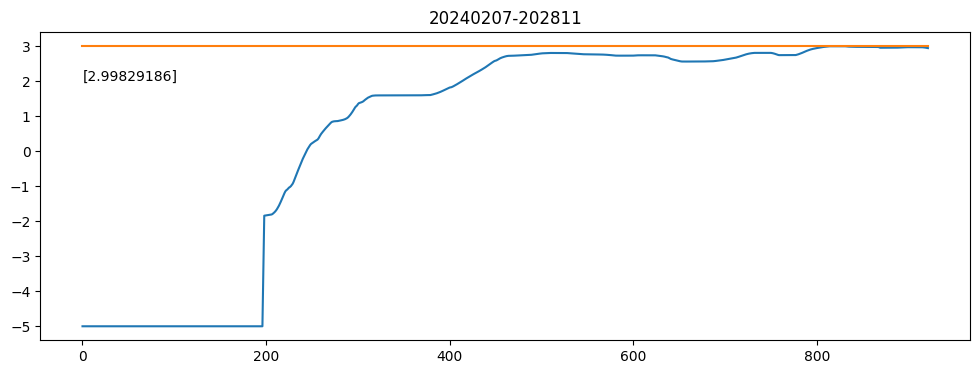

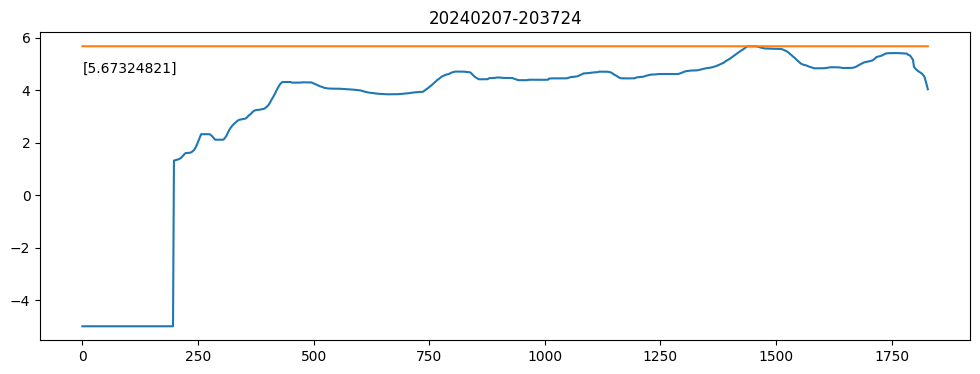

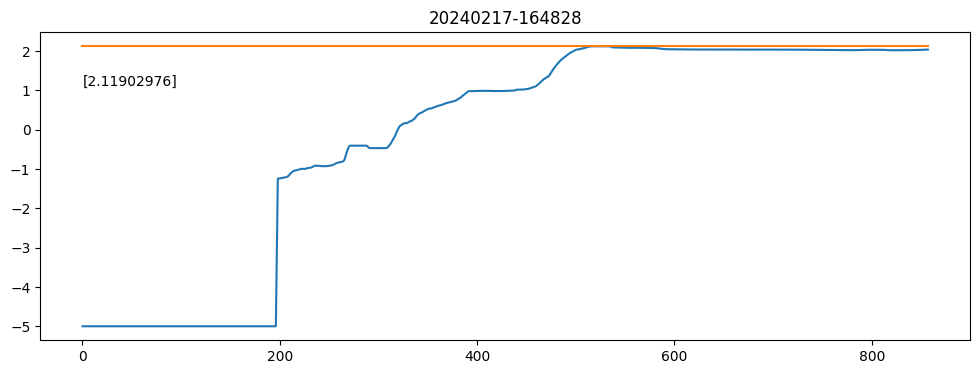

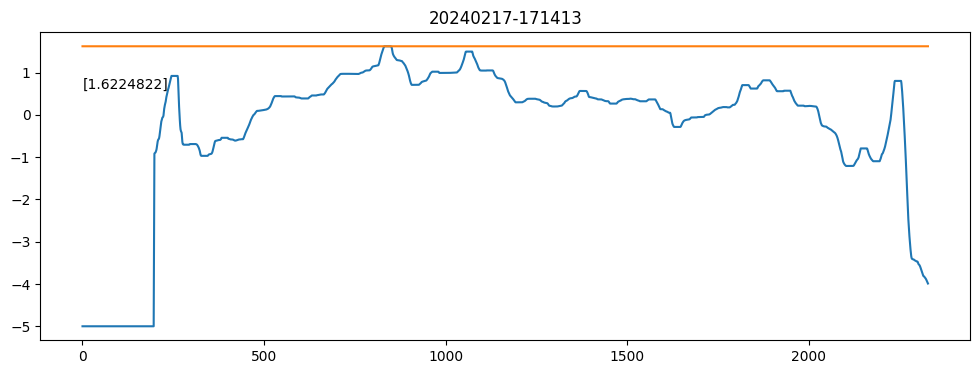

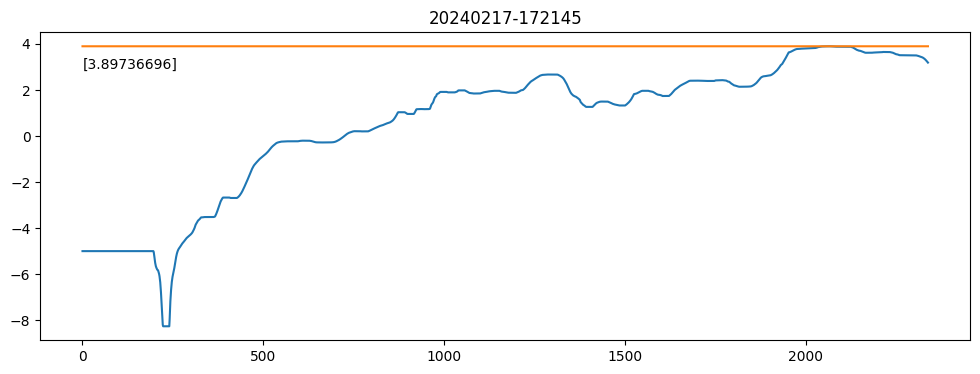

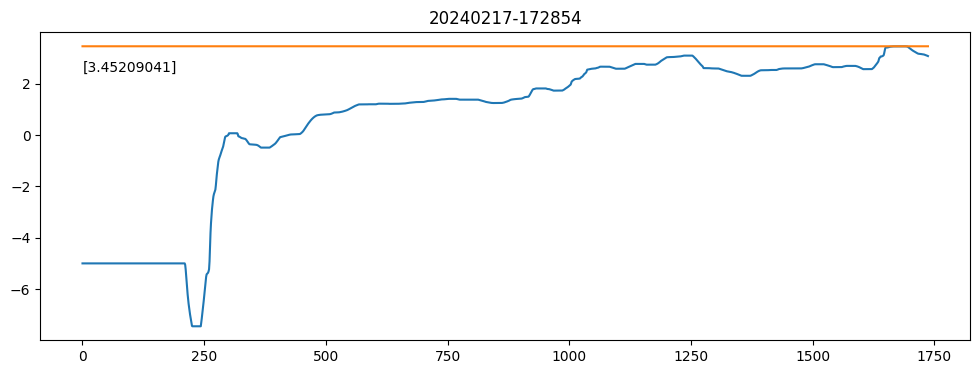

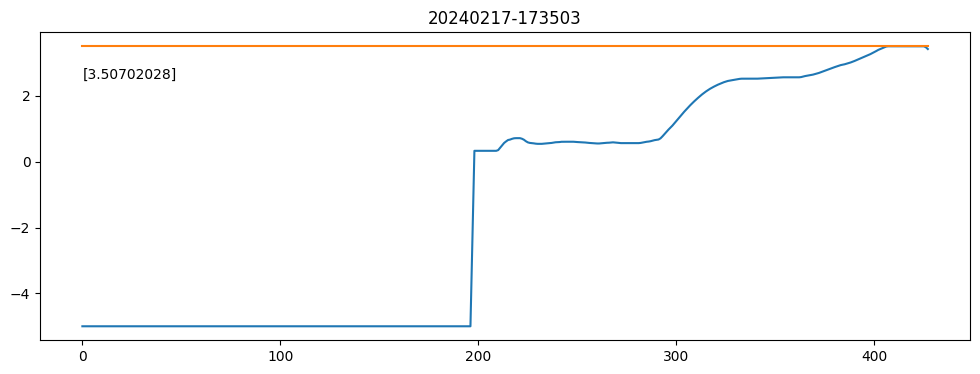

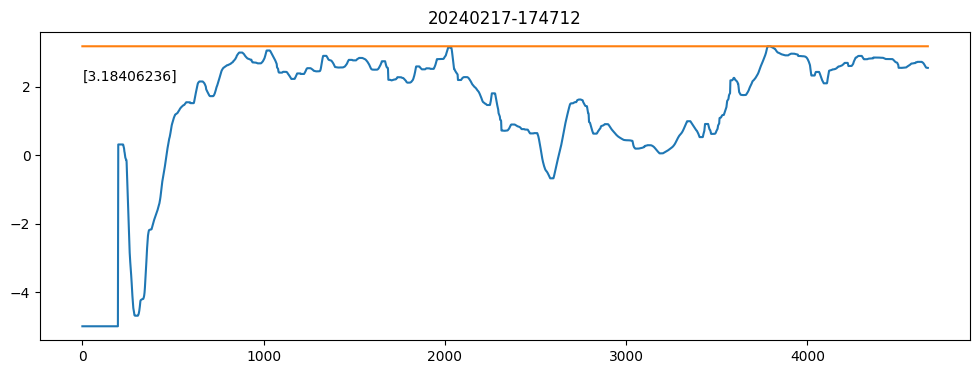

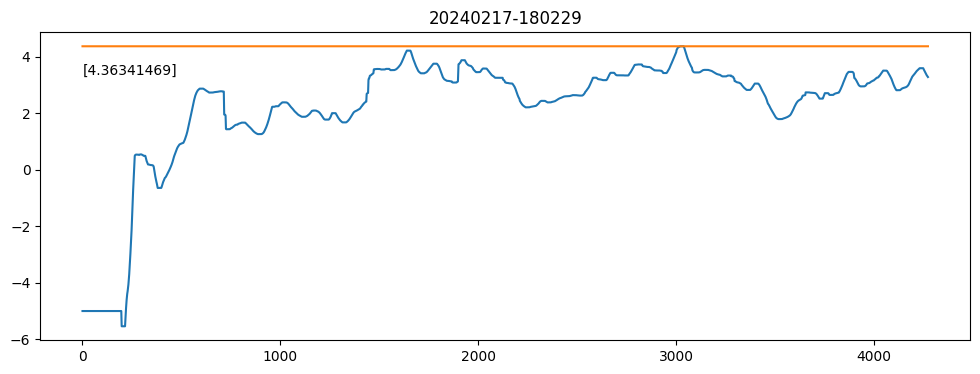

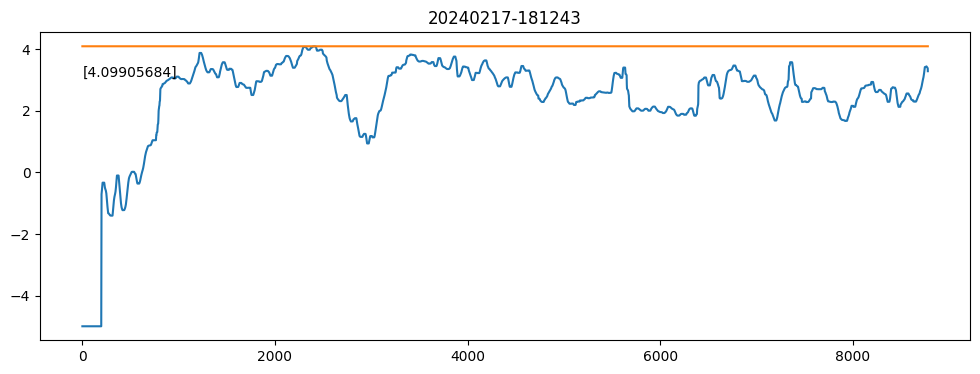

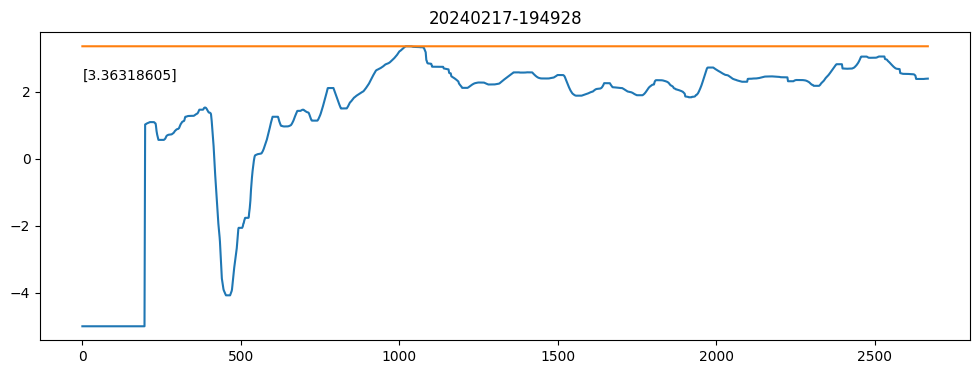

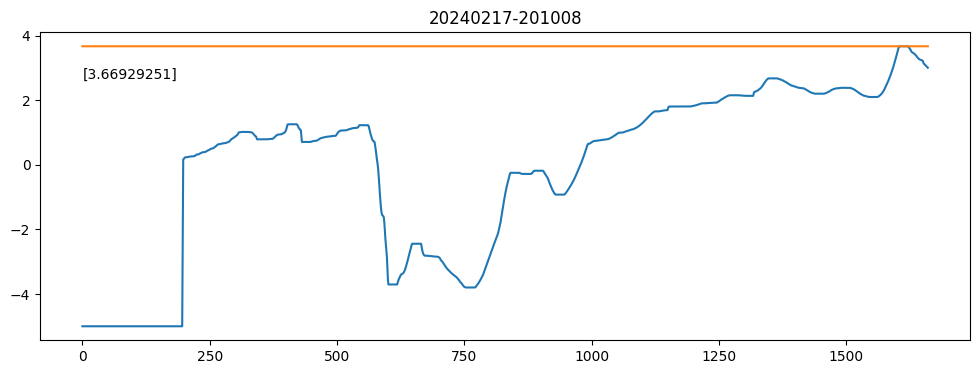

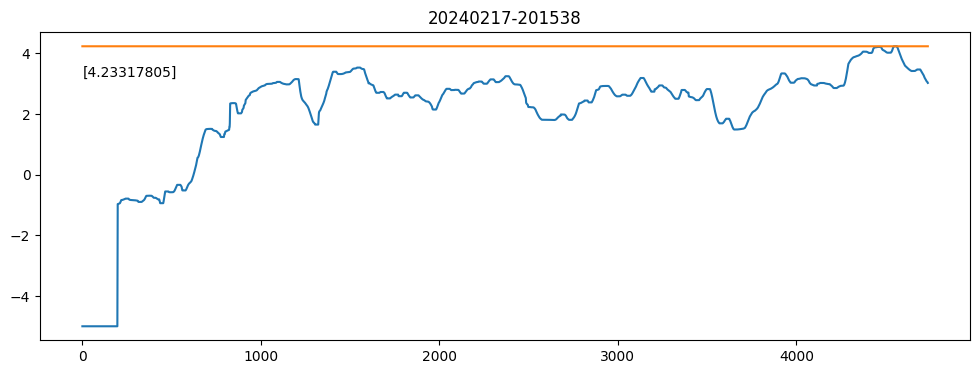

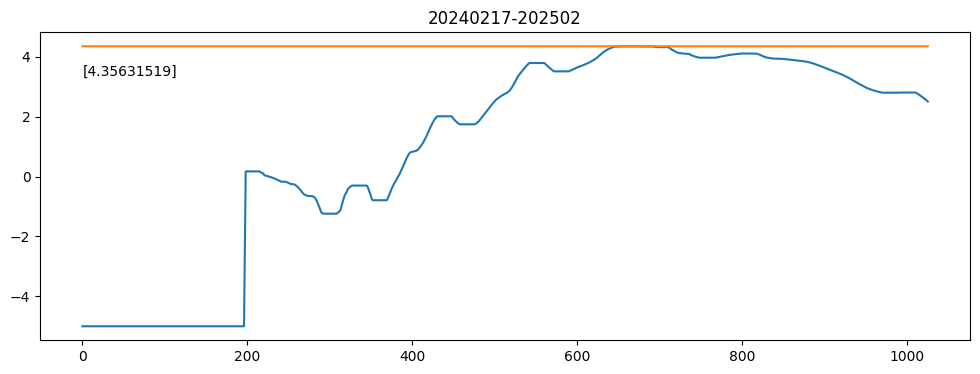

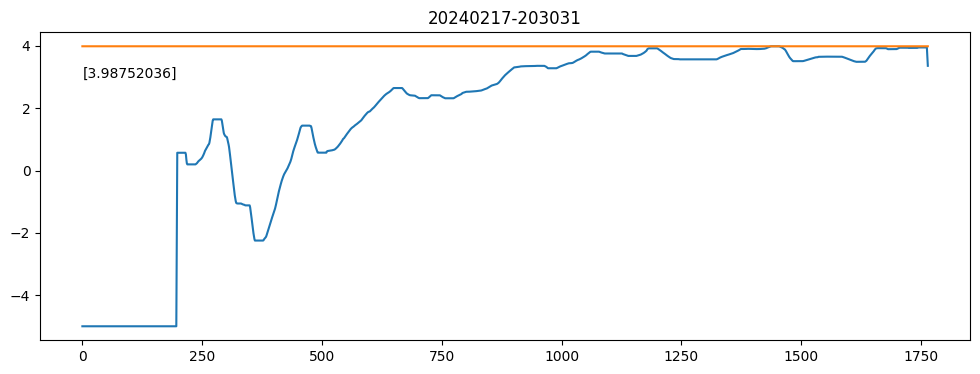

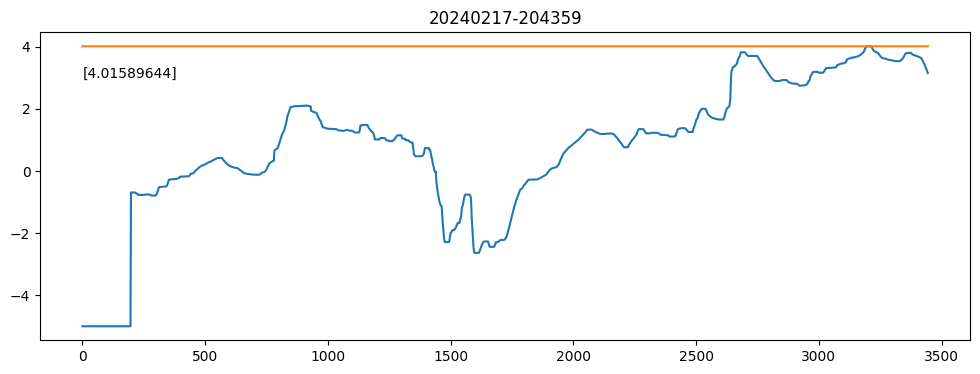

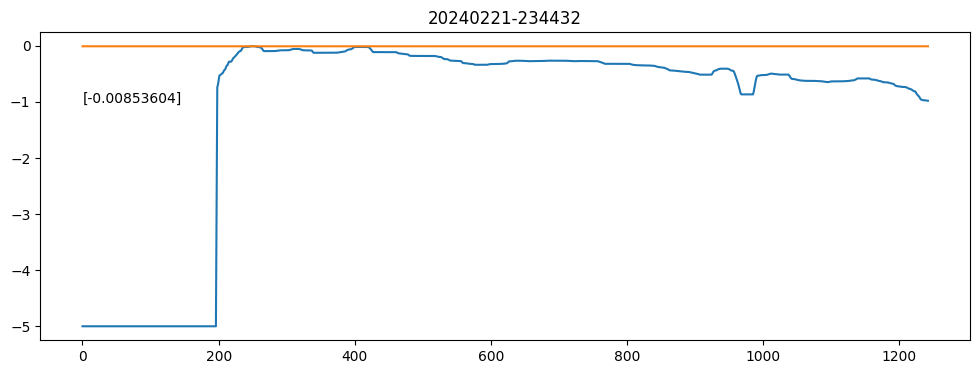

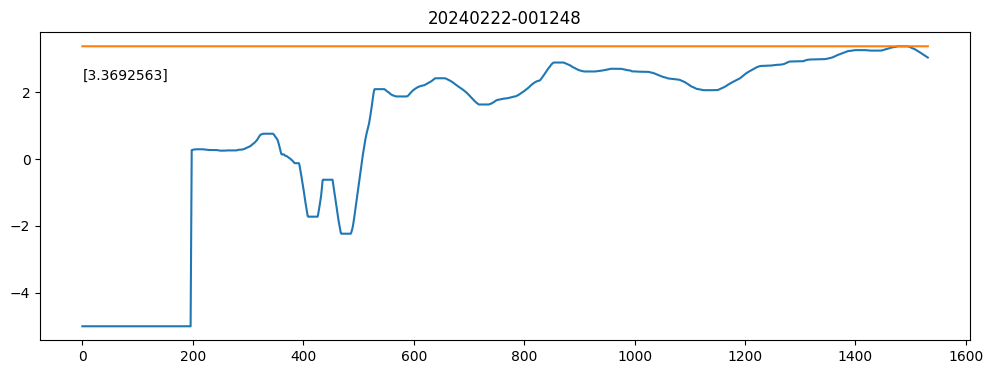

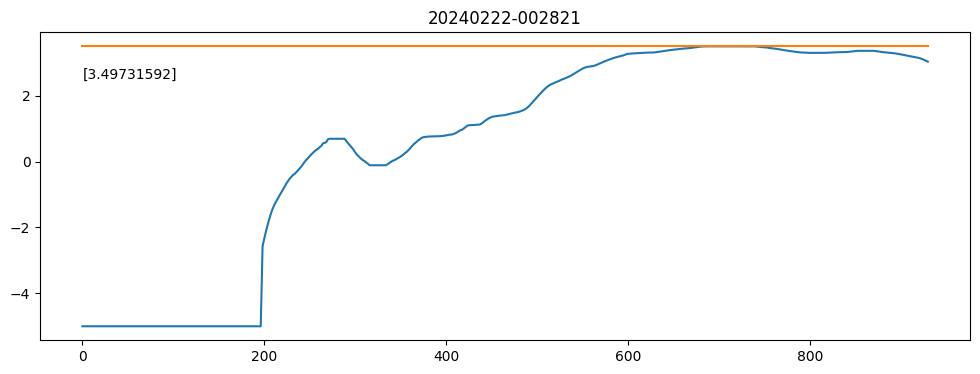

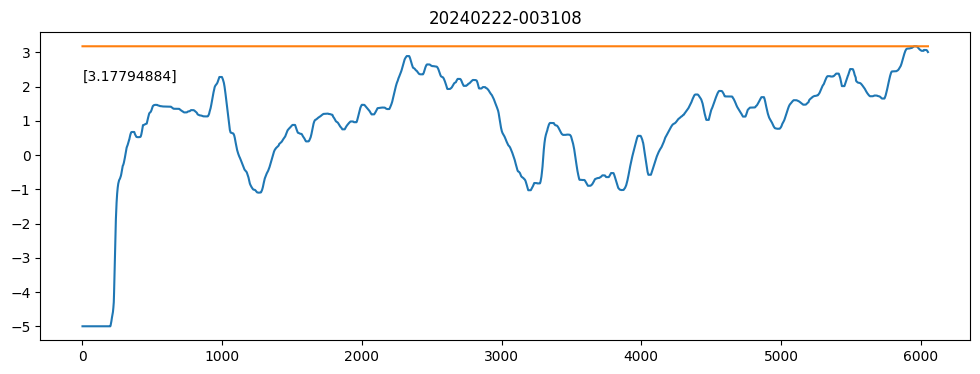

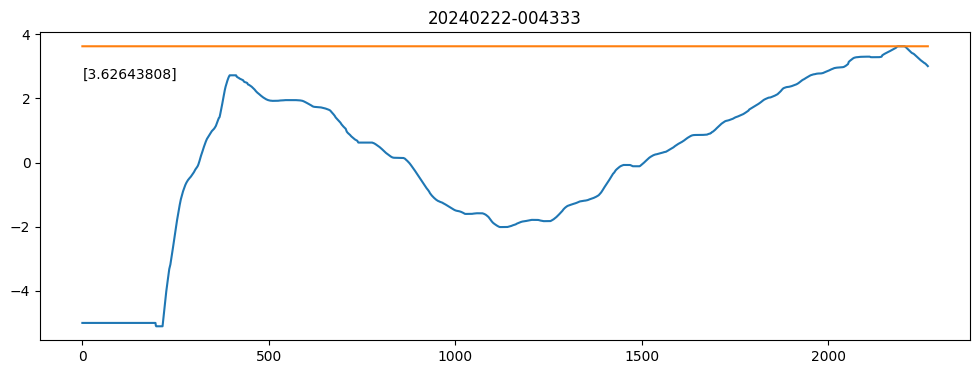

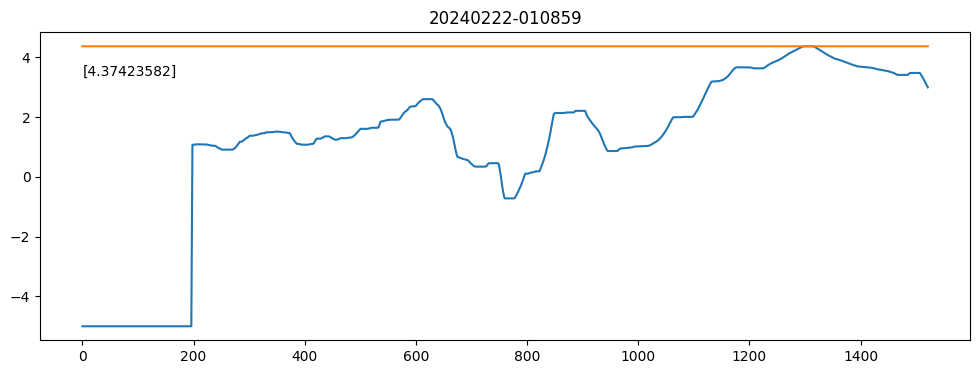

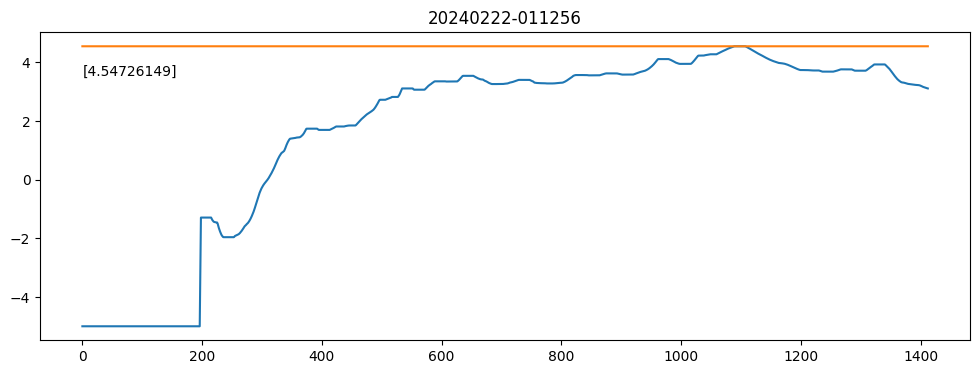

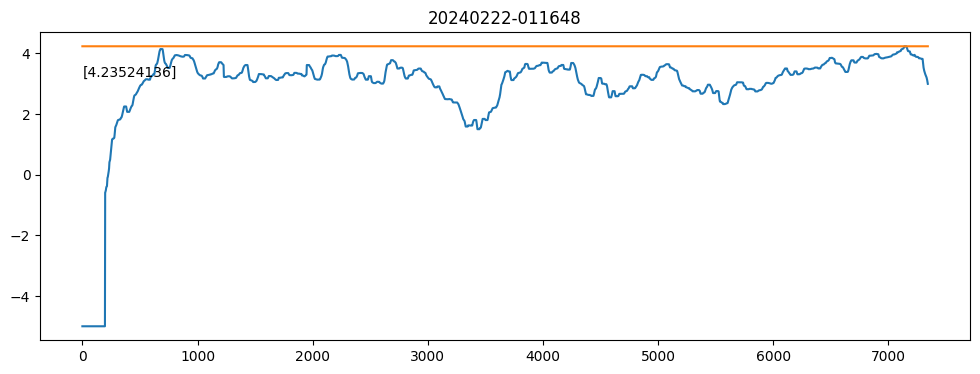

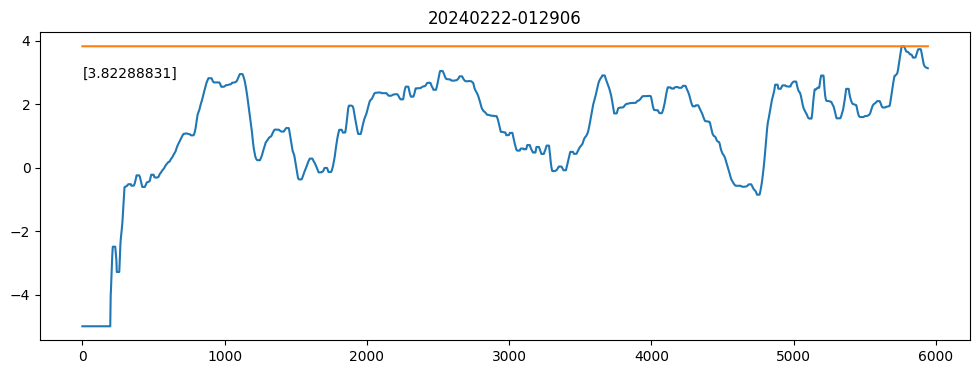

In [246]:
plt.rcParams['figure.figsize'] = (12,4)
for g in psi.keys():
    m = max(psi[g])
    l = len(psi[g])
    plt.plot(np.arange(0, l) , psi[g])
    plt.plot(np.arange(0, l) , [ m ] * l)
    plt.annotate(m, (0, m - 1))
    plt.title(g)
    plt.show()
